In [4]:
import torch
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim
#from torchsummary import summary
import torch.optim.lr_scheduler as scheduler
from tqdm import trange, tqdm
import numpy as np
from torch.utils.data.sampler import BatchSampler
import matplotlib.pyplot as plt
from torchvision import models
from torch.optim import lr_scheduler
from collections import Counter
import math
import matplotlib.image as mpimg
# transforms.ColorJitter()
# transforms.autoaugment()
# transforms.RandomPerspective()

In [5]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device('mps')
device

device(type='mps')

In [6]:
path = '/Users/charlie/ML/Supervised Learning/Charlie/Charlie-Data'

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.5):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
class changeType(object):
    def __init__(self):
        return
        
    def __call__(self, tensor):
        return tensor.type('torch.uint8')

In [9]:
def get_mean_and_std(loader):
  mean = 0. 
  std = 0.
  count = 0
  pbar = tqdm(loader)
  for batch in pbar:
    images,_ = batch
    curr_count = images.size(0)
    images = images.view(curr_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    count += curr_count

  mean /= count
  std /= count
  return mean, std

In [10]:
# transforms_ = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomResizedCrop(1024),
#     transforms.RandomHorizontalFlip(p = 0.25)
# ])
# data = datasets.ImageFolder(root=path, transform=transforms_)
# dataloader = DataLoader(data, batch_size=32)
# mean, std = get_mean_and_std(dataloader)

In [11]:
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]
print(mean, std)

[0.5, 0.5, 0.5] [0.2, 0.2, 0.2]


In [12]:
transforms_ = transforms.Compose([
    transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Resize(512),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.Normalize(mean=mean, std=std),
    AddGaussianNoise(),
    transforms.RandomPerspective(distortion_scale=0.5),
])
data = datasets.ImageFolder(root=path, transform=transforms_)
train, valid = random_split(data, [len(data) - 50, 50])
trainloader = DataLoader(train, batch_size=4, shuffle=True)
validloader = DataLoader(valid, batch_size=4, shuffle=True)

In [13]:
print(dict(Counter(data.targets)), data.classes)

{0: 1349, 1: 423} ['No_Charlie', 'Yes_Charlie']


/Users/charlie/anaconda3/envs/Pytorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


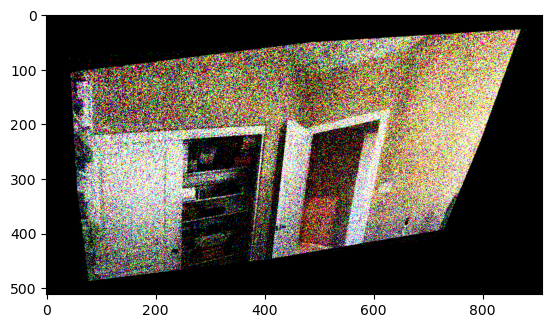

In [14]:
images, label = next(iter(trainloader))
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [15]:
model = models.resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = Adam(model.parameters(), lr=0.01)

# lambda1 = lambda epoch: epoch / 10
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda1)

/Users/charlie/anaconda3/envs/Pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/charlie/anaconda3/envs/Pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# summary(model.to('cpu'), (3, 1024, 1024))

In [17]:
max_accuracy = 0
model = model.to(device)
criterion = criterion.to(device)
for epoch in range(3):
    model.train()
    model_loss = 0
    pbar = tqdm(trainloader)
    for batch in pbar:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        model_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # scheduler.step()
    model_loss /= len(trainloader)
    model.eval()
    correct = 0
    incorrect = 0
    for batch in validloader:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, preditced = torch.max(outputs.data, 1)
        correct += (preditced == y).float().sum()
        incorrect += (preditced != y).float().sum()
    print(f"Epoch: {epoch + 1} Accuracy: {correct / (correct + incorrect) * 100} Loss: {model_loss}")
    if max_accuracy <= correct / (correct + incorrect):
      max_accuracy = correct / (correct + incorrect)
      torch.save(model, 'model')
      print('Saved')
print(max_accuracy)

100%|██████████| 431/431 [12:02<00:00,  1.68s/it]   


Epoch: 1 Accuracy: 88.0 Loss: 0.4357154569901924
Saved


100%|██████████| 431/431 [04:58<00:00,  1.44it/s]


Epoch: 2 Accuracy: 94.0 Loss: 0.31499651078515084
Saved


100%|██████████| 431/431 [2:33:33<00:00, 21.38s/it]   


Epoch: 3 Accuracy: 100.0 Loss: 0.25003458370149123
Saved
tensor(1., device='mps:0')


In [18]:
torch.save(model, 'model')

In [19]:
max_accuracy

tensor(1., device='mps:0')

In [20]:
correctImg = []
correctImgLabel = []
wrongImg = []
wrongImgLabel = []
for batch in validloader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    model = model.to(device)
    outputs = model(X)
    _, preditced = torch.max(outputs.data, 1)
    for i in range(len(preditced)):
        if (preditced[i] == y[i]):
            correctImg.append(np.transpose(X[i].to('cpu').numpy()))
            correctImgLabel.append(y[i])
        else:
            wrongImg.append(np.transpose(X[i].to('cpu').numpy()))
            wrongImgLabel.append(y[i])

In [21]:
def displayImg(input, label):
    plt.figure()
    f, axarr = plt.subplots(len(input) + 1, 1)
    for i in range(len(input)):
        axarr[i].imshow(input[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

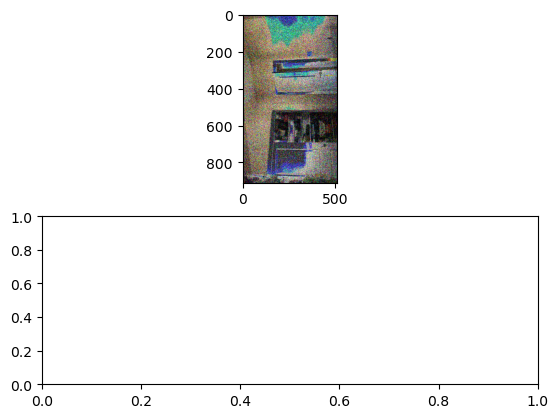

In [25]:
displayImg(wrongImg, wrongImgLabel)

Without Freezing layers: Final_Accuracy = 97%

With Freezing layers: Final_Accuracy =  100%

SGD: 100%

ADAM: 98


Batch Size
4: 9min